Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

This source code is licensed under the license found in the watermark_anything.NSE file in the root directory of this source tree.

The project is MIT-licensed, as found in the LICENSE file of the github.


## DistSeal - Learning to Watermark in the Latent Spaces of Generative Models

[ [Paper](https://scontent-sjc3-1.xx.fbcdn.net/v/t39.2365-6/603028033_905511885552755_4967480041688018421_n.pdf?_nc_cat=110&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=J19JF6eIvJwQ7kNvwGOlV-n&_nc_oc=AdkofKPvU4h-p-wqZYs65ShxPFF29k7MXqy57K2n2_2hu1moVwrOeypVGF3qS-8DDIY4z4NzWznVWs3rGsJwG9ic&_nc_zt=14&_nc_ht=scontent-sjc3-1.xx&_nc_gid=no6j3gWFvtcttlBIMCparw&oh=00_AfmbS2lgg8iiY16EfKbCK4XE849IJ1z9JkTNn2scKWeqRQ&oe=694AAF2D) ] [ [Github](https://github.com/facebookresearch/distseal) ]  [ [Blog](https://ai.meta.com/research/publications/distilling-latent-space-watermarkers-into-generative-image-models/) ]


Clone repo:


In [7]:
!git clone https://github.com/facebookresearch/distseal.git

Install requirements:

In [ ]:
%cd distseal
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124
!pip install -e .

Before running the code below, ensure to add the `deps` to your system path:

In [ ]:
# Or in command line: `export PYTHONPATH=$PYTHONPATH:distseal/deps
import sys
sys.path.append('/content/distseal/deps')

## Load models and run watermarking

> __Note__: We strongly recommend to use a GPU for the examples below. For CPU (setting `device="cpu"`), it should work too, but much slower.


We give examples below for RAR-XL where one can choose to use in-model watermarking either in the generator by specifying `in_model_type = "generator"` or in the latent_decoder by specifying `in_model_type = "latent_decoder"`.

EfficientViT not found.
CompressAI package not found. Install with pip install compressai


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Taming Transformers not found. Install for VQGAN support


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


attention mode is flash
File https://dl.fbaipublicfiles.com/distseal/rar_xl_wm__w1.5.pt downloaded successfully to /content/distseal/checkpoints/distseal/rar_xl_wm__w1.5.pt


/content/distseal/deps/rar/modeling/quantizer/quantizer.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/distseal/deps/rar/modeling/quantizer/quantizer.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/distseal/deps/rar/modeling/quantizer/quantizer.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/distseal/deps/rar/modeling/quantizer/quantizer.py:162: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/distseal/deps/rar/modeling/quantizer/quantizer.py:166: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torc

File https://huggingface.co/fun-research/TiTok/resolve/main/maskgit-vqgan-imagenet-f16-256.bin downloaded successfully to /content/distseal/checkpoints/fun-research/TiTok/resolve/main/maskgit-vqgan-imagenet-f16-256.bin


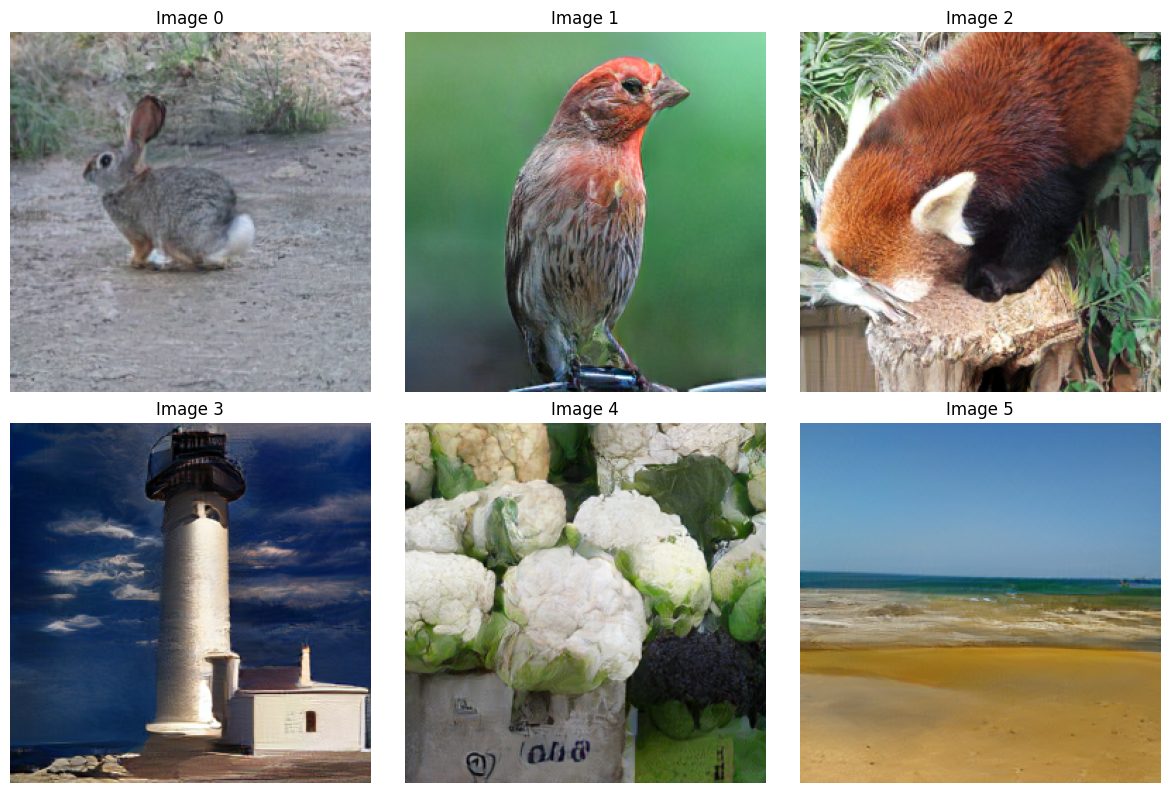

In [12]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

from distseal.utils.metrics import message_accuracy
from distseal.loader import load_generator, load_decoder, load_detector

device = "cuda"

# Choose to use RAR distilled generator or the distilled latent decoder.
in_model_type = "generator"  # "generator" or "latent_decoder"

if in_model_type == "generator":
    generator = load_generator("rar_xl_distseal.yaml", device=device)
    tokenizer = load_decoder("maskgit_base.yaml", device=device)
    detector_yaml = "detector_rar.yaml"
elif in_model_type == "latent_decoder":
    generator = load_generator("rar_xl_base.yaml", device=device)
    tokenizer = load_decoder("maskgit_distseal_postquant.yaml", device=device)
    detector_yaml = "detector_maskgit_postquant.yaml"

# Generate images from ImageNet classes.
labels = [torch.tensor(v) for v in [330, 12, 387, 437, 938, 978]]
labels = torch.LongTensor(labels).to(device)

tokens = generator.generate(
    labels,
    guidance_scale=4.0,
    guidance_decay="constant",
    guidance_scale_pow=0.0,
    randomize_temperature=0.0,
    softmax_temperature_annealing=False,
)

# Decode the sequences of tokens into images.
images = tokenizer.decode(tokens)
images = (torch.clamp(images, 0.0, 1.0) * 255.0).to(dtype=torch.uint8).cpu()

# Visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, img in enumerate(images):
    axes[idx].imshow(img.permute(1, 2, 0).numpy())
    axes[idx].axis('off')
    axes[idx].set_title(f'Image {idx}')

plt.tight_layout()
plt.show()

## Detection of the watermarks:

To detect watermarks from images, download the extractor and the message,
then feed images in tensor format with values between 0 and 1. For RAR-XL,
256x256 images are expected.

In [13]:
detector, secret_msg = load_detector(detector_yaml, device=device)

msg_pred = detector.detect_watermark(images.to(device) / 255.0)
msg_gt = secret_msg.repeat((msg_pred.shape[0], 1))
bit_acc = message_accuracy(secret_msg, msg_pred)
print(f"Average bit accuracy: {bit_acc * 100:.2f}%")

File https://dl.fbaipublicfiles.com/distseal/detector_rar.pt downloaded successfully to /content/distseal/checkpoints/distseal/detector_rar.pt
File https://dl.fbaipublicfiles.com/distseal/detector_rar_msg.txt downloaded successfully to /content/distseal/checkpoints/distseal/detector_rar_msg.txt
Average bit accuracy: 95.05%
